In [16]:
""" 

DESCRIPTION

1. Plot showing first and last glacier ice exposure from albedo time-series.

"""

import numpy as np
import netCDF4
import glob
import xarray as xr
import matplotlib.pyplot as plt

In [240]:
# Define path
path = '/Users/jryan4/Dropbox (University of Oregon)/research/snowfall/data/'

# Define save path
savepath = '/Users/jryan4/Dropbox (University of Oregon)/research/snowfall/figures/'

In [21]:
albedo = xr.open_dataset(path + 'modis_albedo_intermediate/MOD10A1_Albedo_16v02_2010.nc', engine='netcdf4')
exposure = xr.open_dataset(path + 'modis_exposure_intermediate/MOD10A1_albedo_dates_16v02_2010.nc', engine='netcdf4')

In [107]:
# Convert 0s to NaNs
expo_masked = exposure.where(exposure['first_55'] != 0)

# Find median indices
medians = np.argwhere(expo_masked['first_55'].values == 183)

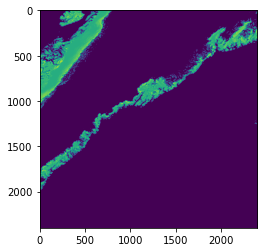

In [259]:
plt.imshow(exposure['first_55'])

In [283]:
# Get single pixel time-series
pixel = 231
print(medians[pixel][0], medians[pixel][1])
albedo_test = albedo['albedo'][medians[pixel][0], medians[pixel][1], :]

# Filter out NaN values
albedo_test = albedo_test.where(albedo_test > 0)
albedo_test = albedo_test.where(albedo_test < 100)

117 348


In [284]:
# Get number of valid albedo observations
valid_obs = np.count_nonzero(~np.isnan(albedo_test))

# Perform filter (i.e. remove if two standard deviations from mean)
rolling_mean = albedo_test.rolling(z=11, min_periods=1, center=True).mean()
rolling_std = albedo_test.rolling(z=11, min_periods=1, center=True).std()
rolling_std = rolling_std * 2

In [285]:
# Calculate difference between pixel value and rolling mean
difference = np.abs(albedo_test - rolling_mean)

# Mask values that are more than two standard deviations from the mean
mask = (difference < rolling_std)

# Calculate 11-day rolling median to be used as the timeseries
rolling_median = albedo_test.where(mask == True).rolling(z=11, min_periods=3, center=True).median()

In [286]:
# Replace value with less than 10% valid observations with 100
rolling_valid = rolling_median.where((valid_obs > 10), 100)

In [287]:
# Calculate first and last day of bare ice exposure
bare_ice_60 = rolling_median.where(rolling_valid < 60)
bare_ice_55 = rolling_median.where(rolling_valid < 55)

# Calculate number of bare ice days
valid_bare_ice = np.repeat(np.count_nonzero(~np.isnan(bare_ice_55)), albedo_test.shape[0])

In [288]:
# Replace values where bare ice duration is less than 7 days with NaN
bare_ice_60 = bare_ice_60.where((valid_bare_ice > 7), np.nan)
bare_ice_55 = bare_ice_55.where((valid_bare_ice > 7), np.nan)

In [289]:
# Replace all values with day of year and get first and last bare ice date
first_bare_ice_60 = bare_ice_60.where(np.isnan(bare_ice_60), bare_ice_60['z']).min(axis=0).astype('int16')
last_bare_ice_60 = bare_ice_60.where(np.isnan(bare_ice_60), bare_ice_60['z']).max(axis=0).astype('int16')

# Replace all values with day of year and get first and last bare ice date
first_bare_ice_55 = bare_ice_55.where(np.isnan(bare_ice_55), bare_ice_55['z']).min(axis=0).astype('int16')
last_bare_ice_55 = bare_ice_55.where(np.isnan(bare_ice_55), bare_ice_55['z']).max(axis=0).astype('int16')

Text(0.03, 0.85, 'd')

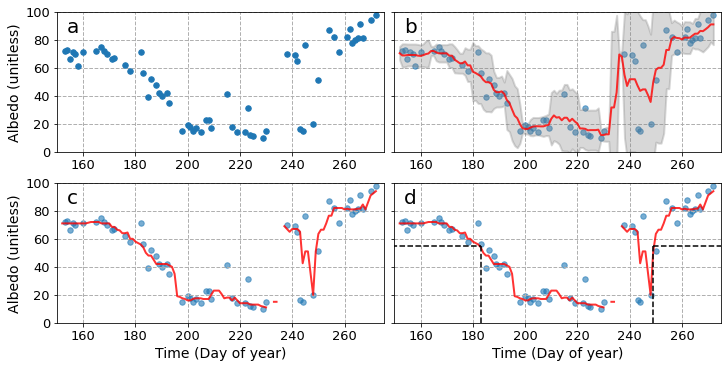

In [293]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 5), sharey=True, layout='constrained')

dot = 30
ax1.scatter(albedo['day_of_year'], albedo_test, s=dot, zorder=2)
ax2.scatter(albedo['day_of_year'], albedo_test, s=dot, alpha=0.6, zorder=2)
ax2.plot(albedo['day_of_year'], rolling_mean, lw=2, color='r', alpha=0.8, zorder=3)
ax2.fill_between(albedo['day_of_year'], rolling_mean + rolling_std, rolling_mean - rolling_std, lw=2, color='grey', alpha=0.3, zorder=2)
ax3.scatter(albedo['day_of_year'], albedo_test.where(mask == True), s=dot, alpha=0.6)
ax3.plot(albedo['day_of_year'], rolling_median, lw=2, color='r', alpha=0.8)
ax4.scatter(albedo['day_of_year'], albedo_test.where(mask == True), s=dot, alpha=0.6)
ax4.plot(albedo['day_of_year'], rolling_median, lw=2, color='r', alpha=0.8)
ax4.plot((first_bare_ice_55.values,first_bare_ice_55.values),(0, 55),c='black', ls='dashed')
ax4.plot((0,first_bare_ice_55.values),(55, 55),c='black', ls='dashed')
ax4.plot((last_bare_ice_55.values,last_bare_ice_55.values),(0, 55),c='black', ls='dashed')
ax4.plot((last_bare_ice_55.values, 275),(55, 55),c='black', ls='dashed')

for ax in [ax1, ax3]:
    ax.set_ylabel('Albedo (unitless)', fontsize=14)
    
for ax in [ax3, ax4]:
    ax.set_xlabel('Time (Day of year)', fontsize=14)

for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(ls='dashed', lw=1, zorder=1)
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.set_ylim(0, 100)
    ax.set_xlim(150, 275)

ax1.text(0.03, 0.85, "a", fontsize=20, transform=ax1.transAxes)
ax2.text(0.03, 0.85, "b", fontsize=20, transform=ax2.transAxes)
ax3.text(0.03, 0.85, "c", fontsize=20, transform=ax3.transAxes)
ax4.text(0.03, 0.85, "d", fontsize=20, transform=ax4.transAxes)

#fig.savefig(savepath + 'fig_sx_first_last_ice.pdf')